In [14]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [15]:
df = pd.read_excel('Minor Project Data set (Stock Price Prediction) (1).xlsx', sheet_name='Stock Price dataset')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
df.set_index('Date', inplace=True)
features = df[['Open', 'High', 'Low', 'Volume', 'Close']]


In [16]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(features)

In [17]:
training_data_len = int(np.ceil(len(scaled_data) * 0.8))
train_data = scaled_data[0:training_data_len, :]
test_data = scaled_data[training_data_len - 60:, :]

In [18]:
X_train, y_train = [], []
for i in range(60, len(train_data)):
    X_train.append(train_data[i - 60:i])
    y_train.append(train_data[i, 4])
X_train, y_train = np.array(X_train), np.array(y_train)

In [19]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))

In [20]:

X_test, y_test = [], features['Close'][training_data_len:]
for i in range(60, len(test_data)):
    X_test.append(test_data[i - 60:i])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [21]:
model = Sequential()
model.add(Bidirectional(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))))
model.add(Dropout(0.3))
model.add(Bidirectional(LSTM(units=100, return_sequences=False)))
model.add(Dropout(0.3))
model.add(Dense(units=50))
model.add(Dense(units=1))


In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [24]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

In [26]:
history = model.fit(X_train, y_train, batch_size=32, epochs=100, validation_split=0.2, callbacks=[early_stop, lr_scheduler])

Epoch 1/100
19/19 [==============================] - 23s 528ms/step - loss: 0.0139 - val_loss: 0.0032 - lr: 0.0010
Epoch 2/100
19/19 [==============================] - 6s 287ms/step - loss: 0.0031 - val_loss: 0.0017 - lr: 0.0010
Epoch 3/100
19/19 [==============================] - 5s 261ms/step - loss: 0.0021 - val_loss: 0.0029 - lr: 0.0010
Epoch 4/100
19/19 [==============================] - 4s 197ms/step - loss: 0.0019 - val_loss: 0.0031 - lr: 0.0010
Epoch 5/100
19/19 [==============================] - 2s 85ms/step - loss: 0.0018 - val_loss: 0.0018 - lr: 0.0010
Epoch 6/100
19/19 [==============================] - 2s 93ms/step - loss: 0.0018 - val_loss: 0.0048 - lr: 0.0010
Epoch 7/100
19/19 [==============================] - 2s 84ms/step - loss: 0.0015 - val_loss: 0.0015 - lr: 0.0010
Epoch 8/100
19/19 [==============================] - 2s 87ms/step - loss: 0.0017 - val_loss: 0.0027 - lr: 0.0010
Epoch 9/100
19/19 [==============================] - 2s 86ms/step - loss: 0.0016 - val_loss

In [27]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((np.zeros((predictions.shape[0], 4)), predictions), axis=1))[:, 4]

7/7 [==============================] - 1s 21ms/step


In [28]:
train = df[:training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

C:\Users\vvaru\AppData\Local\Temp\ipykernel_2612\3983594056.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


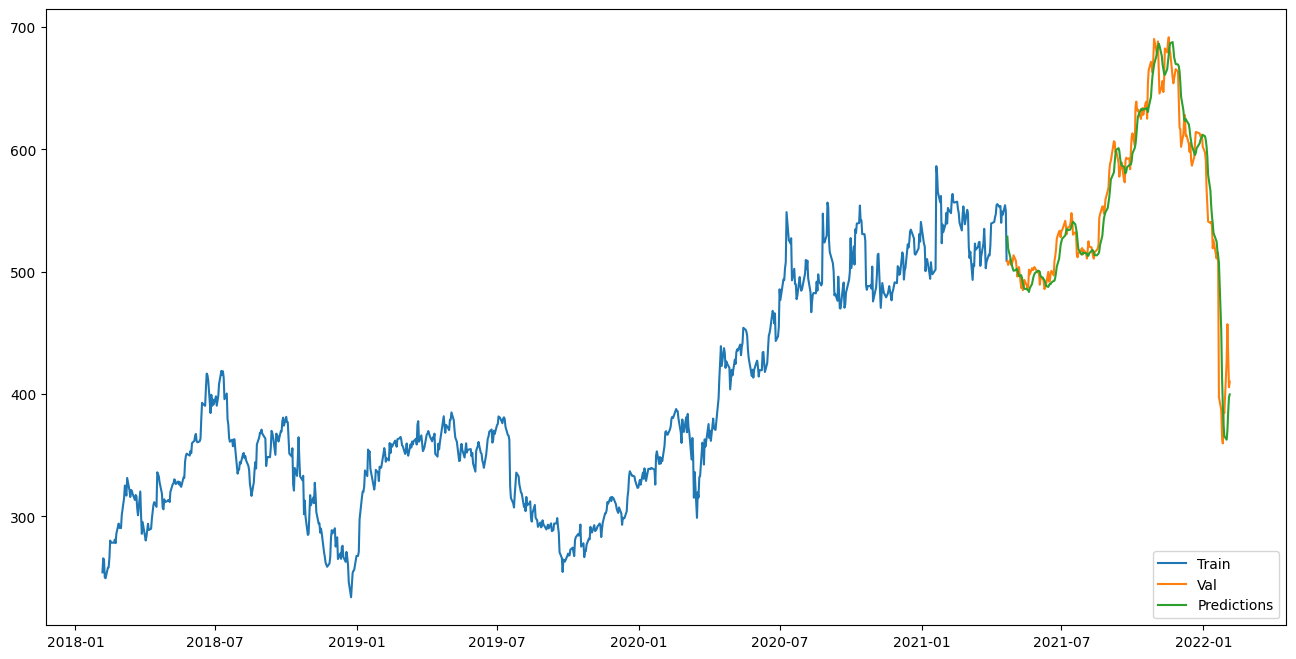

In [29]:
plt.figure(figsize=(16, 8))
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()